<a href="https://colab.research.google.com/github/debashisdotchatterjee/Early-Detection-of-Severe-Influenza-Seasons/blob/main/Early_Detection_of_Severe_Influenza_Season_2026.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<>:263: SyntaxWarning: invalid escape sequence '\m'
<>:266: SyntaxWarning: invalid escape sequence '\m'
<>:263: SyntaxWarning: invalid escape sequence '\m'
<>:266: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipython-input-883966411.py:263: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(dfp["t"], dfp["mu_wili"], label="Baseline mean $\mu_t$", linewidth=1.4)
/tmp/ipython-input-883966411.py:266: SyntaxWarning: invalid escape sequence '\m'
  plt.fill_between(dfp["t"], lower, upper, alpha=0.25, label="Baseline band $\mu_t \pm 1\sigma_t$")


Outputs will be saved to: FLUVIEW_AIM_RUN_20260210_045836
ILI rows: 834

ILI sample
| location   |   epiweek |   year |   week |    wili |     ili |
|------------|-----------|--------|--------|---------|---------|
| nat        |    201001 |   2010 |      1 | 1.90712 | 1.98284 |
| nat        |    201002 |   2010 |      2 | 1.86738 | 1.82749 |
| nat        |    201003 |   2010 |      3 | 1.88072 | 1.92606 |
| nat        |    201004 |   2010 |      4 | 1.96908 | 1.92495 |
| nat        |    201005 |   2010 |      5 | 2.11387 | 2.08877 |
| nat        |    201006 |   2010 |      6 | 2.09695 | 2.03434 |
| nat        |    201007 |   2010 |      7 | 1.90294 | 1.97649 |
| nat        |    201008 |   2010 |      8 | 1.96951 | 1.99362 |
| nat        |    201009 |   2010 |      9 | 1.92331 | 1.85383 |
| nat        |    201010 |   2010 |     10 | 1.89659 | 1.8673  |

Hospitalization endpoint not available in this run (proceeding with ILI-only).

Z-score coverage: 0.686
Saved: FLUVIEW_AIM_RUN_20260210

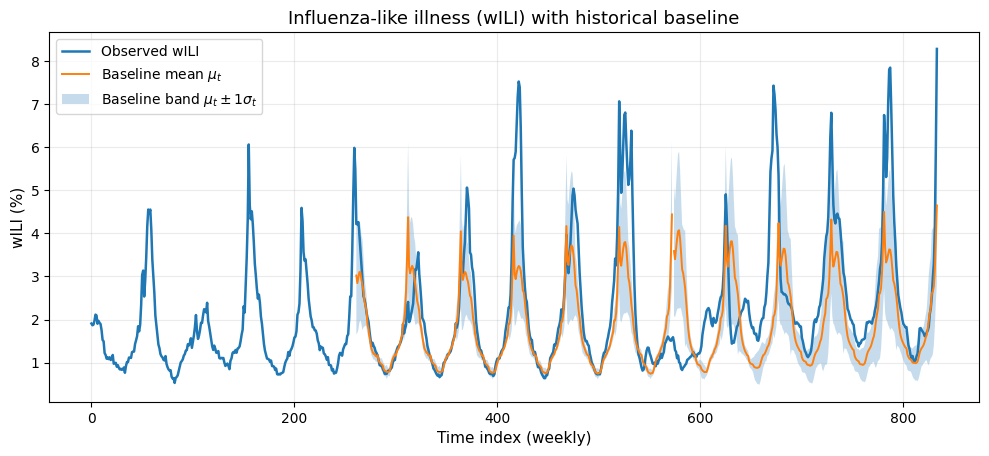

Saved: FLUVIEW_AIM_RUN_20260210_045836/figs/plot2_Zt_threshold.png


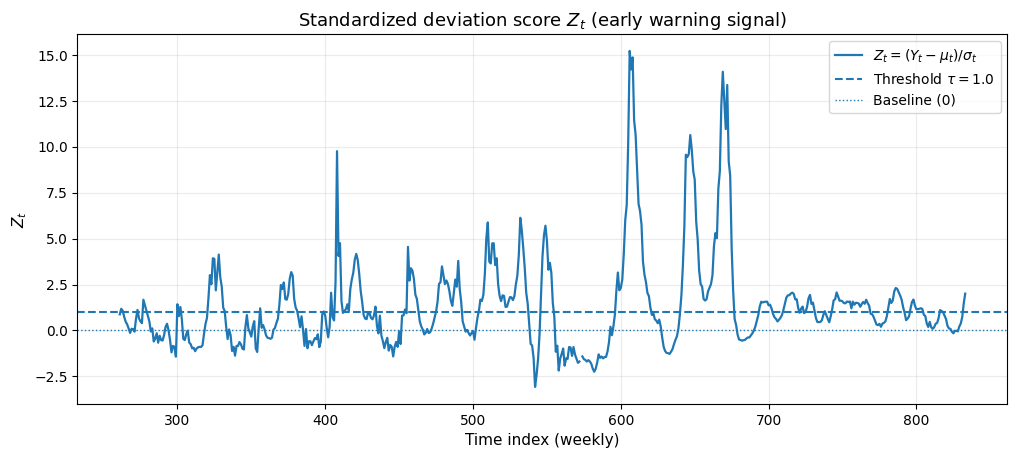

Saved: FLUVIEW_AIM_RUN_20260210_045836/figs/plot3_Pt_persistence.png


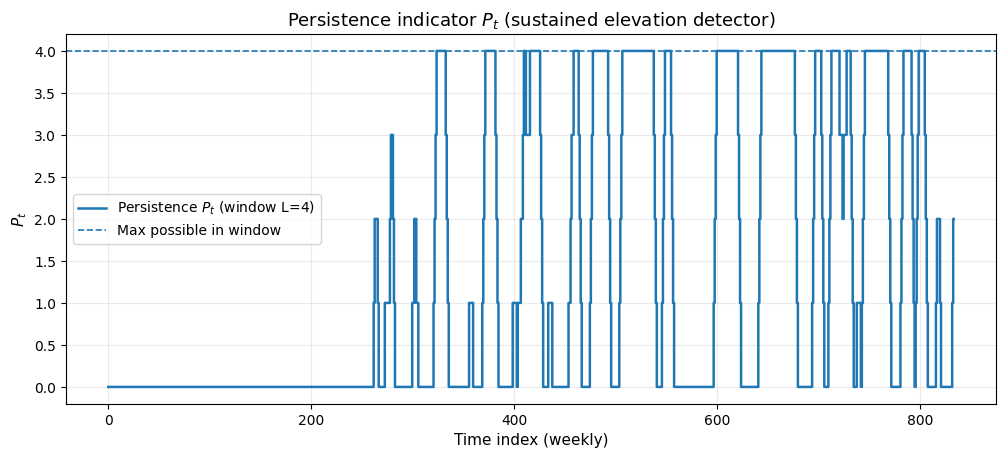

Saved: FLUVIEW_AIM_RUN_20260210_045836/figs/plot4_top_seasons_severity.png


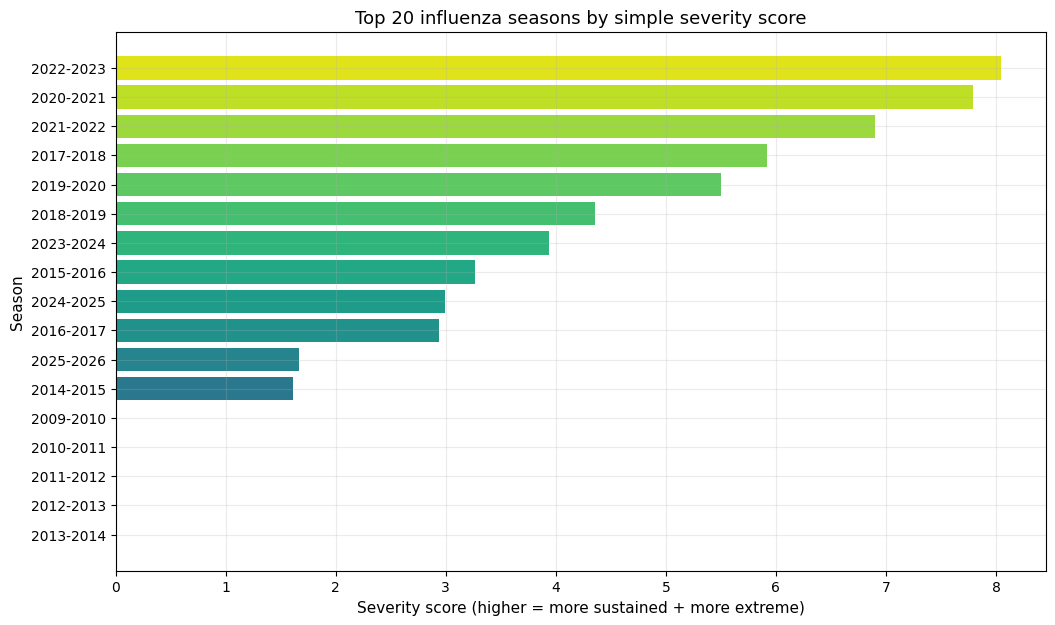

Saved: FLUVIEW_AIM_RUN_20260210_045836/figs/plot5_Z_heatmap_season_week.png


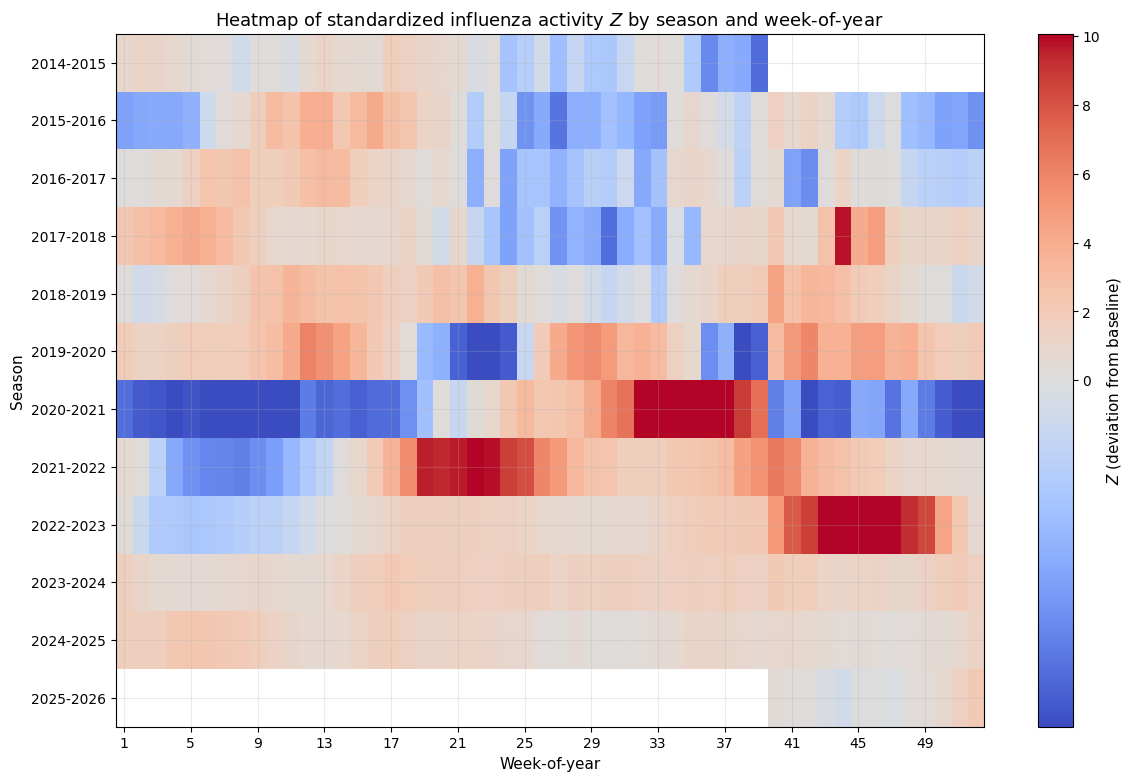

Saved: FLUVIEW_AIM_RUN_20260210_045836/tables/weekly_series.csv
Saved: FLUVIEW_AIM_RUN_20260210_045836/tables/weekly_series.html


Weekly series (first rows)
(showing first 25 rows)
| location   |   epiweek |   year |   week | season_label   |     wili |   mu_wili |   sd_wili |   Z |   I |   P |
|------------|-----------|--------|--------|----------------|----------|-----------|-----------|-----|-----|-----|
| nat        |    201001 |   2010 |      1 | 2009-2010      | 1.90712  |       nan |       nan | nan |   0 |   0 |
| nat        |    201002 |   2010 |      2 | 2009-2010      | 1.86738  |       nan |       nan | nan |   0 |   0 |
| nat        |    201003 |   2010 |      3 | 2009-2010      | 1.88072  |       nan |       nan | nan |   0 |   0 |
| nat        |    201004 |   2010 |      4 | 2009-2010      | 1.96908  |       nan |       nan | nan |   0 |   0 |
| nat        |    201005 |   2010 |      5 | 2009-2010      | 2.11387  |       nan |       nan | nan |   0 |   0 |
| nat        

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


DONE ✅  All plots are in: FLUVIEW_AIM_RUN_20260210_045836/figs and tables are in: FLUVIEW_AIM_RUN_20260210_045836/tables


In [1]:
# ============================================================
# AIM-Style Influenza Surveillance Analysis (CDC FluView via Delphi Epidata)
# Applies the methodology: baseline μ_t, σ_t; Z_t; exceedance I_t; persistence P_t
# Produces MANY good-looking plots + tables
# Auto-saves everything into a timestamped folder and zips it
# Colab-ready ✅
# ============================================================

# ---------- (1) Install & imports ----------
!pip -q install delphi-epidata pandas numpy matplotlib scipy tabulate

import os, re, math, shutil, textwrap, datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from scipy.stats import spearmanr

from delphi_epidata import Epidata

# For nicer table printing in notebook
from tabulate import tabulate

# ---------- (2) Output folder ----------
run_id = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
out_dir = f"FLUVIEW_AIM_RUN_{run_id}"
fig_dir = os.path.join(out_dir, "figs")
tab_dir = os.path.join(out_dir, "tables")
os.makedirs(fig_dir, exist_ok=True)
os.makedirs(tab_dir, exist_ok=True)
print("Outputs will be saved to:", out_dir)

def savefig(name, dpi=200):
    path = os.path.join(fig_dir, name)
    plt.savefig(path, dpi=dpi, bbox_inches="tight")
    print("Saved:", path)

def save_table(df, name):
    csv_path = os.path.join(tab_dir, f"{name}.csv")
    html_path = os.path.join(tab_dir, f"{name}.html")
    df.to_csv(csv_path, index=False)
    df.to_html(html_path, index=False)
    print("Saved:", csv_path)
    print("Saved:", html_path)

def show_table(df, title=None, max_rows=25):
    if title:
        print("\n" + title)
    d = df.copy()
    if len(d) > max_rows:
        d = d.head(max_rows)
        print(f"(showing first {max_rows} rows)")
    print(tabulate(d, headers="keys", tablefmt="github", showindex=False))


# ============================================================
# (3) Download FluView ILI data
#     We'll use national level ("nat") by default.
#     You can change regions to ['hhs1','hhs2',...], or add states if needed.
# ============================================================

def fetch_fluview_ili(locations=("nat",), start_ew=201001, end_ew=202552):
    """
    Fetch FluView outpatient ILI data.
    Returns a DataFrame with columns: location, epiweek, year, week, wili, ili, ...
    """
    resp = Epidata.fluview(list(locations), Epidata.range(start_ew, end_ew))
    if resp.get("result", -1) != 1:
        raise RuntimeError(f"Epidata error: {resp}")
    df = pd.DataFrame(resp["epidata"])
    df["location"] = df["region"].astype(str)
    df["epiweek"] = df["epiweek"].astype(int)
    df["year"] = df["epiweek"] // 100
    df["week"] = df["epiweek"] % 100
    # Keep only sensible week numbers
    df = df[(df["week"] >= 1) & (df["week"] <= 53)].copy()
    df = df.sort_values(["year","week"]).reset_index(drop=True)
    return df

ili = fetch_fluview_ili(locations=("nat",), start_ew=201001, end_ew=202552)
print("ILI rows:", len(ili))
show_table(ili[["location","epiweek","year","week","wili","ili"]].head(10), "ILI sample")

# ============================================================
# (4) Optional: Download hospitalization (if available via flusurv)
#     NOTE: Availability can vary. If it fails, we'll proceed with ILI-only.
# ============================================================

def fetch_flusurv_hosp(locations=("nat",), start_ew=201001, end_ew=202552):
    """
    Attempt to fetch FluSurv-NET hospitalization rate (where supported).
    Some environments/versions may not support this endpoint for nat.
    We'll try; if it fails, return None.
    """
    try:
        # Delphi Epidata supports flusurv endpoint in many setups
        resp = Epidata.flusurv(list(locations), Epidata.range(start_ew, end_ew))
        if resp.get("result", -1) != 1:
            return None
        df = pd.DataFrame(resp["epidata"])
        df["location"] = df["region"].astype(str)
        df["epiweek"] = df["epiweek"].astype(int)
        df["year"] = df["epiweek"] // 100
        df["week"] = df["epiweek"] % 100
        df = df[(df["week"] >= 1) & (df["week"] <= 53)].copy()
        df = df.sort_values(["year","week"]).reset_index(drop=True)
        # Typical column names include rates by age group; try a reasonable overall
        # We'll keep all columns and later select numeric rate columns.
        return df
    except Exception:
        return None

hosp = fetch_flusurv_hosp(locations=("nat",), start_ew=201001, end_ew=202552)
if hosp is None:
    print("\nHospitalization endpoint not available in this run (proceeding with ILI-only).")
else:
    print("\nHospitalization rows:", len(hosp))
    show_table(hosp.head(10), "Hospitalization sample (raw)")


# ============================================================
# (5) Define influenza season label S_t
#     A common convention: season year is the year in which week >= 40 starts the season.
#     Example: 2019 week 40 belongs to season 2019-2020 -> label 2019.
# ============================================================

def assign_season_year(year, week):
    return year if week >= 40 else (year - 1)

ili["season"] = [assign_season_year(y,w) for y,w in zip(ili["year"], ili["week"])]
# human-friendly season label
ili["season_label"] = ili["season"].astype(str) + "-" + (ili["season"]+1).astype(str)

# ============================================================
# (6) Baseline μ_t, σ_t using expanding historical same-week sets (no look-ahead)
#     For each (week-of-year w), baseline for time t uses only prior years' values
# ============================================================

def expanding_week_baseline(df, value_col, week_col="week", year_col="year"):
    """
    For each row t, compute:
      μ_t = mean of {value in same week w from years < current year}
      σ_t = std  of {value in same week w from years < current year}
    This avoids using future information (good practice for surveillance).
    """
    df = df.copy()
    mu = np.full(len(df), np.nan, dtype=float)
    sd = np.full(len(df), np.nan, dtype=float)

    # Pre-group indices by week number
    for w in sorted(df[week_col].unique()):
        idx = df.index[df[week_col] == w].to_numpy()
        # sort those indices by year then week already globally sorted
        # for each index, use only years < current year
        past_vals = []
        past_years = []
        for i in idx:
            y = int(df.loc[i, year_col])
            # Update past set with entries from strictly earlier years
            # We'll keep a list and filter by year, but efficiently do incremental by scanning in order:
            # Since data sorted by year/week, we can add as we move forward.
            # However, multiple years at same week -> scanning idx already in time order.
            # We can maintain all previous values; at each step, past_vals already from earlier years.
            if len(past_vals) >= 5:
                mu[i] = float(np.mean(past_vals))
                sd_i = float(np.std(past_vals, ddof=1))
                sd[i] = sd_i if sd_i > 1e-12 else np.nan
            # Now add current observation to past pool for subsequent years
            v = df.loc[i, value_col]
            if pd.notnull(v):
                past_vals.append(float(v))
                past_years.append(y)

    df[f"mu_{value_col}"] = mu
    df[f"sd_{value_col}"] = sd
    return df

ili = expanding_week_baseline(ili, "wili")
ili["Z"] = (ili["wili"] - ili["mu_wili"]) / ili["sd_wili"]

# Some early years won't have enough history => Z is NaN; that's expected.
print("\nZ-score coverage:", ili["Z"].notna().mean().round(3))

# ============================================================
# (7) Exceedance I_t and persistence P_t
# ============================================================

TAU = 1.0   # threshold τ (1.0 ~ 1 SD above baseline)
L = 4       # rolling window length L weeks for persistence

ili["I"] = (ili["Z"] >= TAU).astype(int)
ili["P"] = ili["I"].rolling(L, min_periods=1).sum()

# ============================================================
# (8) Season-level severity summary table
# ============================================================

season_summary = (ili
    .groupby(["season","season_label"], as_index=False)
    .agg(
        n_weeks=("epiweek","count"),
        frac_Z_ge_tau=("I","mean"),
        peak_wili=("wili","max"),
        peak_Z=("Z","max"),
        peak_P=("P","max"),
        first_week_Z_ge_tau=("epiweek", lambda x: np.nan),  # placeholder; fill next
    )
)

# First exceedance week per season (where Z >= tau)
first_exceed = (ili[ili["I"]==1]
    .groupby(["season","season_label"], as_index=False)["epiweek"].min()
    .rename(columns={"epiweek":"first_week_Z_ge_tau"})
)

season_summary = season_summary.drop(columns=["first_week_Z_ge_tau"]).merge(
    first_exceed, on=["season","season_label"], how="left"
)

# A simple composite "severity score" (interpretable, not fancy)
# Higher means more sustained and more extreme activity
season_summary["severity_score"] = (
    3.0*season_summary["frac_Z_ge_tau"].fillna(0) +
    0.4*season_summary["peak_Z"].fillna(0) +
    0.2*season_summary["peak_P"].fillna(0)
)

season_summary = season_summary.sort_values("severity_score", ascending=False).reset_index(drop=True)

save_table(season_summary, "season_summary")
show_table(season_summary, "\nSeason summary (sorted by severity_score)", max_rows=20)

# Also save a nice markdown copy-paste table
md_path = os.path.join(tab_dir, "season_summary.md")
with open(md_path, "w") as f:
    f.write(tabulate(season_summary, headers="keys", tablefmt="github", showindex=False))
print("Saved:", md_path)

# ============================================================
# (9) Plot settings (colorful + clean)
#     User explicitly asked for colorful plots, so we use colormaps.
# ============================================================

plt.rcParams.update({
    "figure.figsize": (12, 4.8),
    "axes.grid": True,
    "grid.alpha": 0.25,
    "axes.titlesize": 13,
    "axes.labelsize": 11,
    "legend.frameon": True
})

# ============================================================
# (10) Plot 1: wILI time series + baseline mean band (μ ± 1σ)
# ============================================================

dfp = ili.copy()
# Create a continuous time index for plotting (year-week to ordinal)
dfp["t"] = np.arange(len(dfp))

plt.figure()
plt.plot(dfp["t"], dfp["wili"], label="Observed wILI", linewidth=1.8)
plt.plot(dfp["t"], dfp["mu_wili"], label="Baseline mean $\mu_t$", linewidth=1.4)
upper = dfp["mu_wili"] + dfp["sd_wili"]
lower = dfp["mu_wili"] - dfp["sd_wili"]
plt.fill_between(dfp["t"], lower, upper, alpha=0.25, label="Baseline band $\mu_t \pm 1\sigma_t$")
plt.title("Influenza-like illness (wILI) with historical baseline")
plt.xlabel("Time index (weekly)")
plt.ylabel("wILI (%)")
plt.legend()
savefig("plot1_wili_baseline.png")
plt.show()

# ============================================================
# (11) Plot 2: Z_t time series with threshold τ
# ============================================================

plt.figure()
plt.plot(dfp["t"], dfp["Z"], label="$Z_t = (Y_t-\\mu_t)/\\sigma_t$", linewidth=1.6)
plt.axhline(TAU, linestyle="--", linewidth=1.5, label=f"Threshold $\\tau={TAU}$")
plt.axhline(0.0, linestyle=":", linewidth=1.0, label="Baseline (0)")
plt.title("Standardized deviation score $Z_t$ (early warning signal)")
plt.xlabel("Time index (weekly)")
plt.ylabel("$Z_t$")
plt.legend()
savefig("plot2_Zt_threshold.png")
plt.show()

# ============================================================
# (12) Plot 3: Persistence P_t time series (rolling exceedances)
# ============================================================

plt.figure()
plt.step(dfp["t"], dfp["P"], where="mid", linewidth=1.8, label=f"Persistence $P_t$ (window L={L})")
plt.axhline(L, linestyle="--", linewidth=1.2, label="Max possible in window")
plt.title("Persistence indicator $P_t$ (sustained elevation detector)")
plt.xlabel("Time index (weekly)")
plt.ylabel("$P_t$")
plt.legend()
savefig("plot3_Pt_persistence.png")
plt.show()

# ============================================================
# (13) Plot 4: Season severity bar chart (top 20 seasons)
# ============================================================

topk = 20
ss_top = season_summary.head(topk).iloc[::-1]  # reverse for nicer horizontal bar order

plt.figure(figsize=(12, 7))
colors = plt.cm.viridis(np.linspace(0.15, 0.95, len(ss_top)))
plt.barh(ss_top["season_label"], ss_top["severity_score"], color=colors)
plt.title(f"Top {topk} influenza seasons by simple severity score")
plt.xlabel("Severity score (higher = more sustained + more extreme)")
plt.ylabel("Season")
savefig("plot4_top_seasons_severity.png")
plt.show()

# ============================================================
# (14) Plot 5: Heatmap of Z by (season x week-of-year)
#     This is very visually informative and 'colorful'.
# ============================================================

heat = (ili[["season_label","week","Z"]]
        .dropna()
        .pivot_table(index="season_label", columns="week", values="Z", aggfunc="mean"))

# Sort seasons chronologically
def season_start_year(lbl):
    return int(lbl.split("-")[0])
heat = heat.loc[sorted(heat.index, key=season_start_year)]

plt.figure(figsize=(14, 9))
norm = TwoSlopeNorm(vmin=np.nanquantile(heat.values, 0.02),
                    vcenter=0.0,
                    vmax=np.nanquantile(heat.values, 0.98))
im = plt.imshow(heat.values, aspect="auto", cmap="coolwarm", norm=norm)
plt.colorbar(im, label="$Z$ (deviation from baseline)")
plt.title("Heatmap of standardized influenza activity $Z$ by season and week-of-year")
plt.xlabel("Week-of-year")
plt.ylabel("Season")
plt.xticks(ticks=np.arange(0, heat.shape[1], 4), labels=heat.columns[::4])
plt.yticks(ticks=np.arange(0, heat.shape[0], 1), labels=heat.index)
savefig("plot5_Z_heatmap_season_week.png")
plt.show()

# ============================================================
# (15) Optional: Simple concordance check if hospitalizations exist
#     If we can identify a numeric hospitalization rate column, we compute Z^(H) similarly
# ============================================================

if hosp is not None:
    # Try to pick a reasonable numeric rate column automatically
    numeric_cols = [c for c in hosp.columns if pd.api.types.is_numeric_dtype(hosp[c])]
    # Heuristic: choose column with 'rate' in name if present, else first numeric after epiweek/year/week
    rate_cols = [c for c in numeric_cols if "rate" in c.lower()]
    candidate = None
    for c in rate_cols:
        if c.lower() not in ("epiweek","year","week"):
            candidate = c
            break
    if candidate is None:
        # fallback: choose numeric with enough non-missing
        cand2 = [(c, hosp[c].notna().mean()) for c in numeric_cols if c not in ("epiweek","year","week")]
        cand2 = sorted(cand2, key=lambda x: x[1], reverse=True)
        candidate = cand2[0][0] if cand2 else None

    if candidate is None:
        print("\nHospitalization data present but no suitable numeric rate column detected; skipping linkage plot.")
    else:
        print("\nUsing hospitalization column:", candidate)

        hosp2 = hosp[["epiweek","year","week",candidate]].rename(columns={candidate:"H"}).copy()
        hosp2["season"] = [assign_season_year(y,w) for y,w in zip(hosp2["year"], hosp2["week"])]
        hosp2["season_label"] = hosp2["season"].astype(str) + "-" + (hosp2["season"]+1).astype(str)

        hosp2 = expanding_week_baseline(hosp2, "H")
        hosp2["ZH"] = (hosp2["H"] - hosp2["mu_H"]) / hosp2["sd_H"]

        # Merge with ILI on epiweek
        merged = ili.merge(hosp2[["epiweek","H","ZH"]], on="epiweek", how="inner").sort_values("epiweek")
        merged["t"] = np.arange(len(merged))

        # Table: correlation between Z and ZH (rank-based)
        m = merged.dropna(subset=["Z","ZH"])
        if len(m) >= 20:
            rho, pval = spearmanr(m["Z"], m["ZH"])
        else:
            rho, pval = np.nan, np.nan

        concord = pd.DataFrame([{
            "n_weeks_used": len(m),
            "spearman_rho_Z_vs_ZH": rho,
            "p_value": pval
        }])
        save_table(concord, "concordance_Z_vs_ZH")
        show_table(concord, "\nConcordance between ILI deviation (Z) and hospitalization deviation (Z^H)")

        # Plot: Z and ZH over time (aligned)
        plt.figure()
        plt.plot(merged["t"], merged["Z"], label="ILI deviation $Z_t$", linewidth=1.6)
        plt.plot(merged["t"], merged["ZH"], label="Hosp deviation $Z^{(H)}_t$", linewidth=1.6)
        plt.axhline(TAU, linestyle="--", linewidth=1.2, label=f"Threshold $\\tau={TAU}$")
        plt.axhline(0.0, linestyle=":", linewidth=1.0)
        plt.title("Alignment of outpatient surveillance vs hospitalization burden (standardized)")
        plt.xlabel("Time index (weekly, merged)")
        plt.ylabel("Standardized deviation")
        plt.legend()
        savefig("plot6_Z_vs_ZH_alignment.png")
        plt.show()

        # Save merged dataset
        save_table(merged[["epiweek","year","week","wili","Z","P","H","ZH"]], "merged_ILI_hosp")

# ============================================================
# (16) Save processed weekly series table (for copy-paste)
# ============================================================

weekly_out = ili[["location","epiweek","year","week","season_label","wili","mu_wili","sd_wili","Z","I","P"]].copy()
save_table(weekly_out, "weekly_series")
show_table(weekly_out, "\nWeekly series (first rows)", max_rows=25)

# Also a markdown copy for easy paste
weekly_md = os.path.join(tab_dir, "weekly_series_head.md")
with open(weekly_md, "w") as f:
    f.write(tabulate(weekly_out.head(60), headers="keys", tablefmt="github", showindex=False))
print("Saved:", weekly_md)

# ============================================================
# (17) Zip everything
# ============================================================

zip_base = out_dir  # will create out_dir.zip
zip_path = shutil.make_archive(zip_base, "zip", out_dir)
print("\nCreated ZIP:", zip_path)

# In Colab, offer download
try:
    from google.colab import files
    files.download(zip_path)
except Exception:
    print("If running outside Colab, manually download:", zip_path)

print("\nDONE ✅  All plots are in:", fig_dir, "and tables are in:", tab_dir)
